In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os   # zip file from drive and setup,
import shutil
import zipfile

# Source and destination paths
source_zip = "/content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip"
destination_dir = "/content/FER-2013"

def setup_directory(directory_path):
    """Create directory if it doesn't exist, clear it if it does."""
    # Check if directory exists
    if os.path.exists(directory_path):
        print(f"Directory {directory_path} exists. Clearing contents...")
        # Remove all contents
        for item in os.listdir(directory_path):
            item_path = os.path.join(directory_path, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print(f"Directory {directory_path} cleared.")
    else:
        # Create directory and any necessary parent directories
        print(f"Creating directory {directory_path}...")
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory {directory_path} created.")

def extract_zip(zip_path, extract_to):
    """Extract contents of zip file to specified directory."""
    print(f"Extracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

if __name__ == "__main__":
    # Make sure parent directories exist
    os.makedirs(os.path.dirname(destination_dir), exist_ok=True)

    # Setup the destination directory
    setup_directory(destination_dir)

    # Extract the ZIP file
    if os.path.exists(source_zip):
        extract_zip(source_zip, destination_dir)
        print(f"Successfully extracted {source_zip} to {destination_dir}")
    else:
        print(f"Error: Source file {source_zip} not found.")

Creating directory /content/FER-2013...
Directory /content/FER-2013 created.
Extracting /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip to /content/FER-2013...
Extraction complete.
Successfully extracted /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip to /content/FER-2013


In [11]:
import torch
import numpy as np
from torchvision import transforms

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define constants
DATA_DIR = '/content/FER-2013/all'
NUM_EPOCHS = 6
BATCH_SIZE = 32
NUM_FOLDS = 5
LEARNING_RATE = 0.002
NUM_CLASSES = 7  # assuming 7 emotions in FER-2013

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

Using device: cuda


In [12]:
import os
from PIL import Image
from torch.utils.data import Dataset

class FERDataset(Dataset):
    def __init__(self, data_dir, transform=None, subset=None):
        self.data_dir = data_dir
        self.transform = transform

        # Get emotion classes from train directory
        train_dir = os.path.join(data_dir, 'train')
        self.classes = sorted([d for d in os.listdir(train_dir)
                              if os.path.isdir(os.path.join(train_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = []
        # If subset is specified (train or test), only use that folder
        # Otherwise, use both train and test for cross-validation
        subsets = [subset] if subset else ['train', 'test']

        for subset_name in subsets:
            subset_dir = os.path.join(data_dir, subset_name)
            if not os.path.isdir(subset_dir):
                continue

            for class_name in self.classes:
                class_dir = os.path.join(subset_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        img_path = os.path.join(class_dir, img_name)
                        if os.path.isfile(img_path):  # Make sure it's a file, not a directory
                            self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Handle grayscale images and potential errors
        try:
            image = Image.open(img_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except (IOError, OSError) as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image and the label if there's an error
            image = Image.new('RGB', (224, 224), color=0)

        if self.transform:
            image = self.transform(image)

        return image, label

# Load the dataset (combining train and test for cross-validation)
dataset = FERDataset(DATA_DIR, transform=transform)
print(f"Dataset loaded with {len(dataset)} samples")
print(f"Classes: {dataset.classes}")

Dataset loaded with 46648 samples
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Function to create a model
def create_model():
    # Load pre-trained ResNet-50 model
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASSES)

    # Move model to device
    model = model.to(device)
    return model

# Function to train one epoch
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Function to evaluate model
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


FOLD 1/5


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


Epoch 1/6 - Train Loss: 1.6754, Train Acc: 0.3627, Val Loss: 1.7644, Val Acc: 0.3469
Epoch 2/6 - Train Loss: 1.5817, Train Acc: 0.3985, Val Loss: 1.5361, Val Acc: 0.4248
Epoch 3/6 - Train Loss: 1.5622, Train Acc: 0.4120, Val Loss: 1.6221, Val Acc: 0.3938
Epoch 4/6 - Train Loss: 1.5296, Train Acc: 0.4252, Val Loss: 1.5149, Val Acc: 0.4367
Epoch 5/6 - Train Loss: 1.5207, Train Acc: 0.4283, Val Loss: 1.4408, Val Acc: 0.4553
Epoch 6/6 - Train Loss: 1.4894, Train Acc: 0.4377, Val Loss: 1.5434, Val Acc: 0.4278

Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.06      0.10      1299
     disgust       0.22      0.29      0.25       150
        fear       0.48      0.06      0.11      1329
       happy       0.55      0.64      0.59      2280
     neutral       0.50      0.30      0.37      1637
         sad       0.30      0.73      0.43      1621
    surprise       0.51      0.66      0.57      1014

    accuracy                    

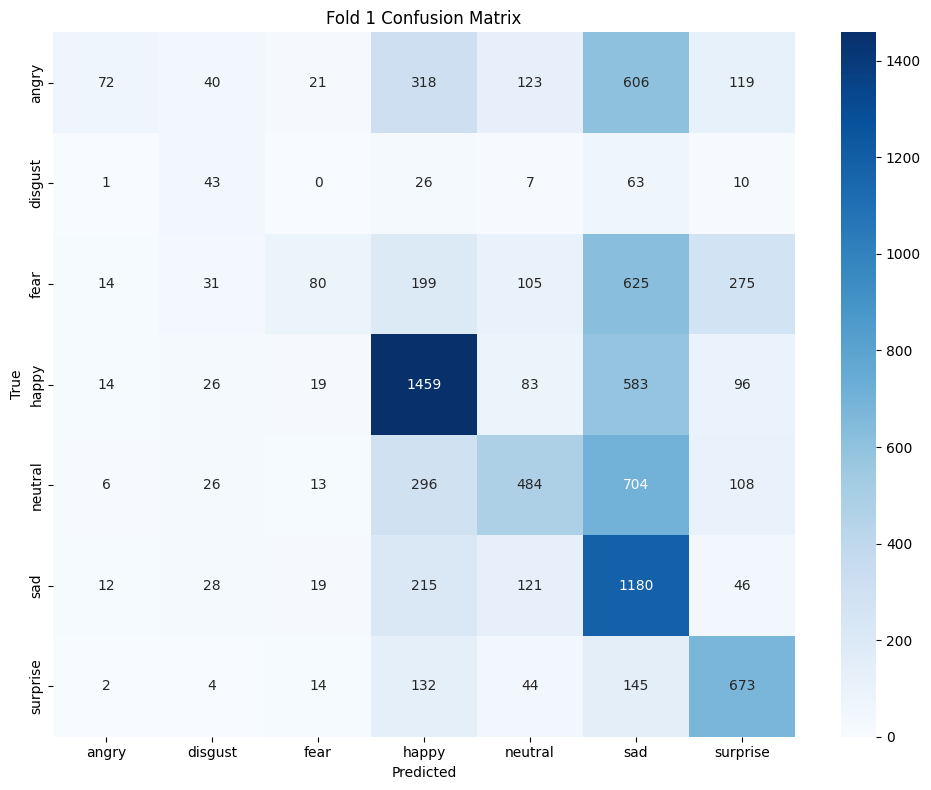


FOLD 2/5
Epoch 1/6 - Train Loss: 1.6632, Train Acc: 0.3623, Val Loss: 1.5314, Val Acc: 0.4129
Epoch 2/6 - Train Loss: 1.5902, Train Acc: 0.4014, Val Loss: 1.6284, Val Acc: 0.3921
Epoch 3/6 - Train Loss: 1.5579, Train Acc: 0.4126, Val Loss: 1.6829, Val Acc: 0.3927
Epoch 4/6 - Train Loss: 1.5423, Train Acc: 0.4204, Val Loss: 1.5292, Val Acc: 0.4244
Epoch 5/6 - Train Loss: 1.5166, Train Acc: 0.4257, Val Loss: 1.6487, Val Acc: 0.3678
Epoch 6/6 - Train Loss: 1.5000, Train Acc: 0.4373, Val Loss: 1.7286, Val Acc: 0.3588

Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.07      0.12      1303
     disgust       0.75      0.02      0.04       147
        fear       0.41      0.07      0.12      1342
       happy       0.74      0.33      0.46      2387
     neutral       0.23      0.89      0.37      1533
         sad       0.39      0.27      0.32      1565
    surprise       0.60      0.55      0.58      1053

    accuracy          

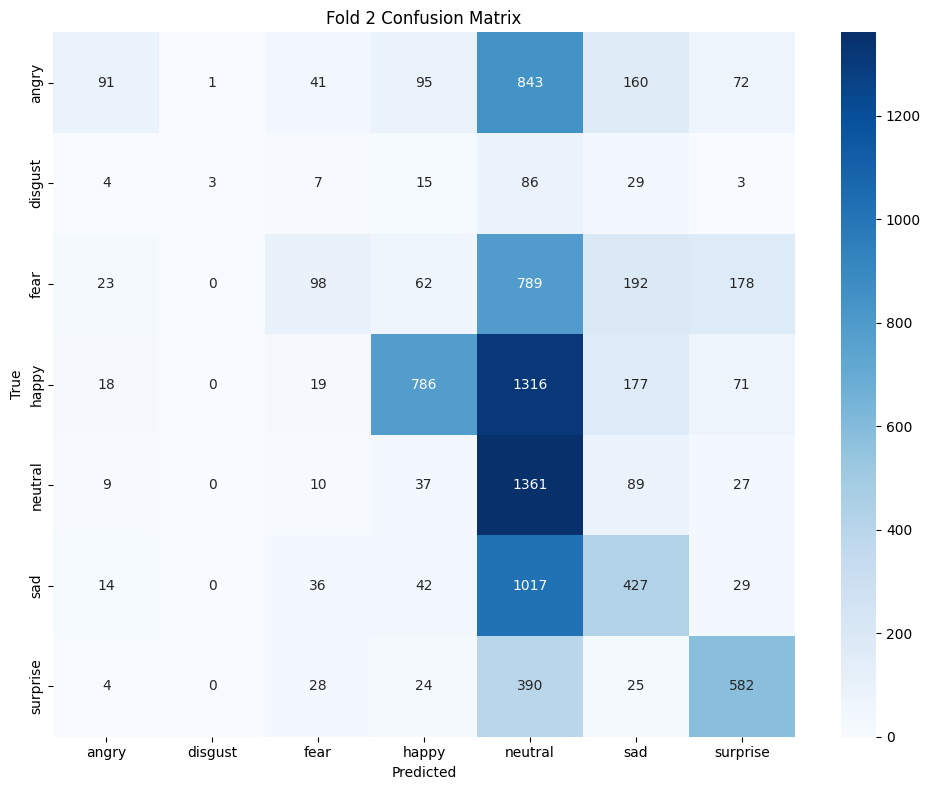


FOLD 3/5
Epoch 1/6 - Train Loss: 1.6657, Train Acc: 0.3610, Val Loss: 1.6833, Val Acc: 0.3703
Epoch 2/6 - Train Loss: 1.6000, Train Acc: 0.3966, Val Loss: 1.5244, Val Acc: 0.4152
Epoch 3/6 - Train Loss: 1.5509, Train Acc: 0.4122, Val Loss: 1.4606, Val Acc: 0.4421
Epoch 4/6 - Train Loss: 1.5455, Train Acc: 0.4174, Val Loss: 1.6983, Val Acc: 0.3973
Epoch 5/6 - Train Loss: 1.5299, Train Acc: 0.4262, Val Loss: 1.5155, Val Acc: 0.4081
Epoch 6/6 - Train Loss: 1.5044, Train Acc: 0.4357, Val Loss: 1.5331, Val Acc: 0.4224

Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.06      0.11      1275
     disgust       0.56      0.04      0.07       127
        fear       0.25      0.47      0.32      1296
       happy       0.69      0.52      0.59      2369
     neutral       0.45      0.34      0.39      1601
         sad       0.33      0.55      0.41      1614
    surprise       0.57      0.56      0.57      1048

    accuracy          

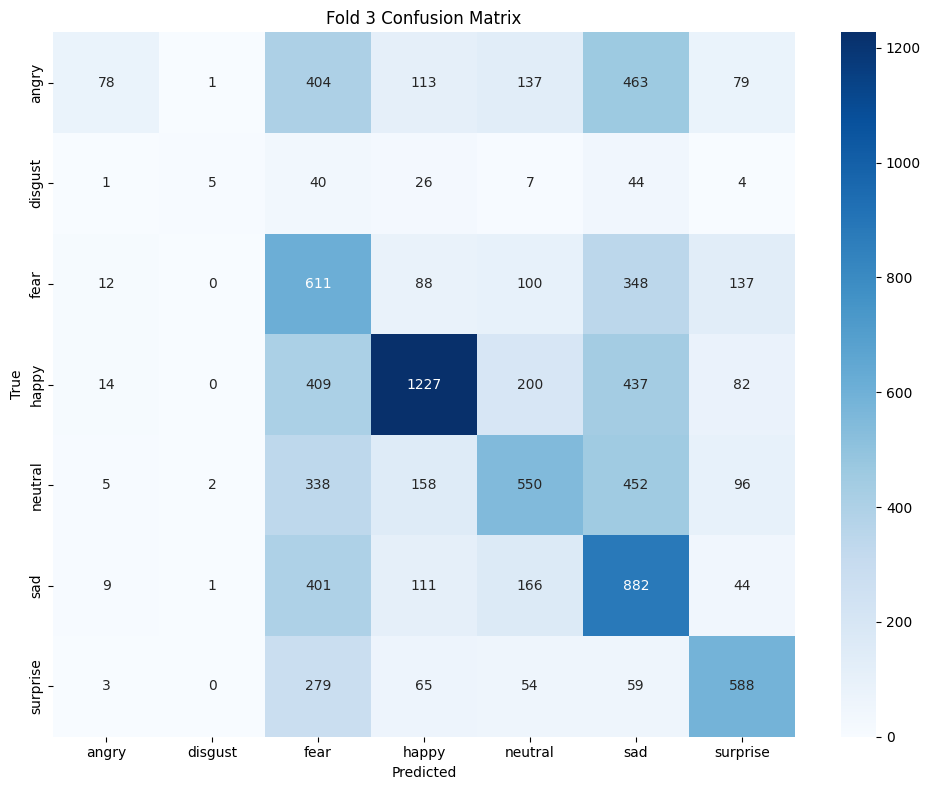


FOLD 4/5
Epoch 1/6 - Train Loss: 1.6767, Train Acc: 0.3587, Val Loss: 1.6817, Val Acc: 0.3649
Epoch 2/6 - Train Loss: 1.5903, Train Acc: 0.3990, Val Loss: 1.5557, Val Acc: 0.4088
Epoch 3/6 - Train Loss: 1.5804, Train Acc: 0.4057, Val Loss: 1.4823, Val Acc: 0.4377
Epoch 4/6 - Train Loss: 1.5413, Train Acc: 0.4194, Val Loss: 1.4908, Val Acc: 0.4332
Epoch 5/6 - Train Loss: 1.5190, Train Acc: 0.4257, Val Loss: 1.4766, Val Acc: 0.4403
Epoch 6/6 - Train Loss: 1.4981, Train Acc: 0.4360, Val Loss: 1.6032, Val Acc: 0.3880

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.04      0.07      1251
     disgust       0.54      0.05      0.10       128
        fear       0.21      0.73      0.33      1364
       happy       0.63      0.56      0.60      2339
     neutral       0.51      0.29      0.37      1642
         sad       0.44      0.12      0.18      1544
    surprise       0.56      0.56      0.56      1061

    accuracy          

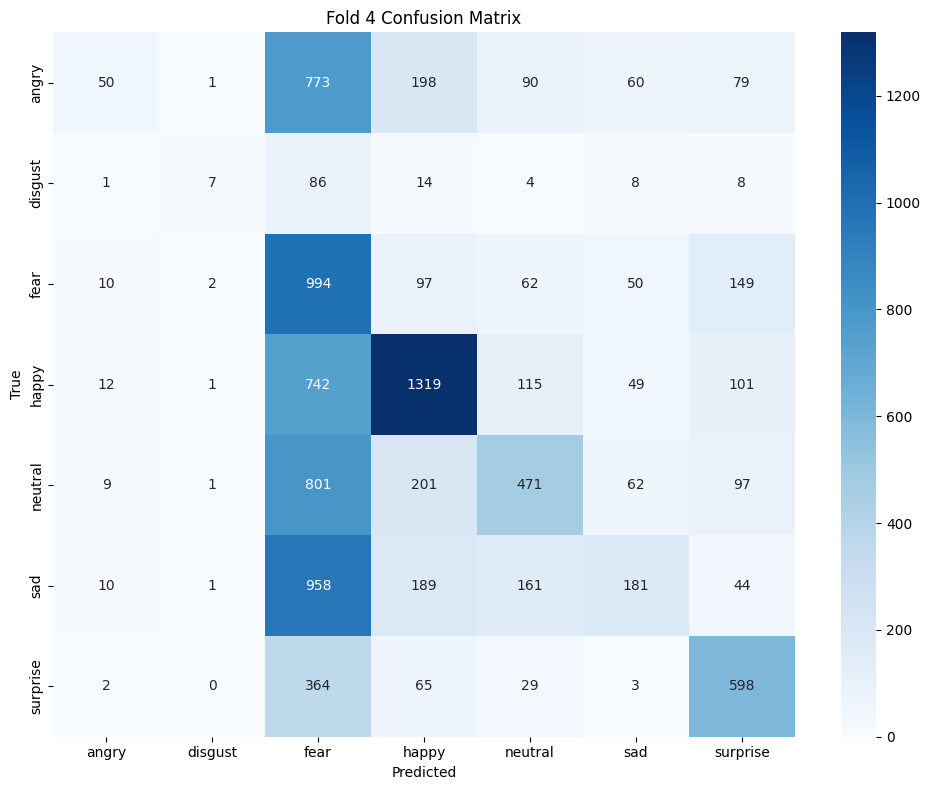


FOLD 5/5
Epoch 1/6 - Train Loss: 1.6725, Train Acc: 0.3607, Val Loss: 1.6146, Val Acc: 0.3990
Epoch 2/6 - Train Loss: 1.5758, Train Acc: 0.4016, Val Loss: 1.5016, Val Acc: 0.4267
Epoch 3/6 - Train Loss: 1.5817, Train Acc: 0.4064, Val Loss: 1.5348, Val Acc: 0.4375
Epoch 4/6 - Train Loss: 1.5274, Train Acc: 0.4229, Val Loss: 1.7752, Val Acc: 0.3427
Epoch 5/6 - Train Loss: 1.5247, Train Acc: 0.4272, Val Loss: 1.5698, Val Acc: 0.4187
Epoch 6/6 - Train Loss: 1.5044, Train Acc: 0.4340, Val Loss: 1.6023, Val Acc: 0.3937

Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.28      0.33      1310
     disgust       0.39      0.16      0.23       158
        fear       0.21      0.64      0.32      1326
       happy       0.59      0.62      0.60      2310
     neutral       0.65      0.10      0.17      1643
         sad       0.38      0.21      0.27      1556
    surprise       0.66      0.49      0.56      1026

    accuracy          

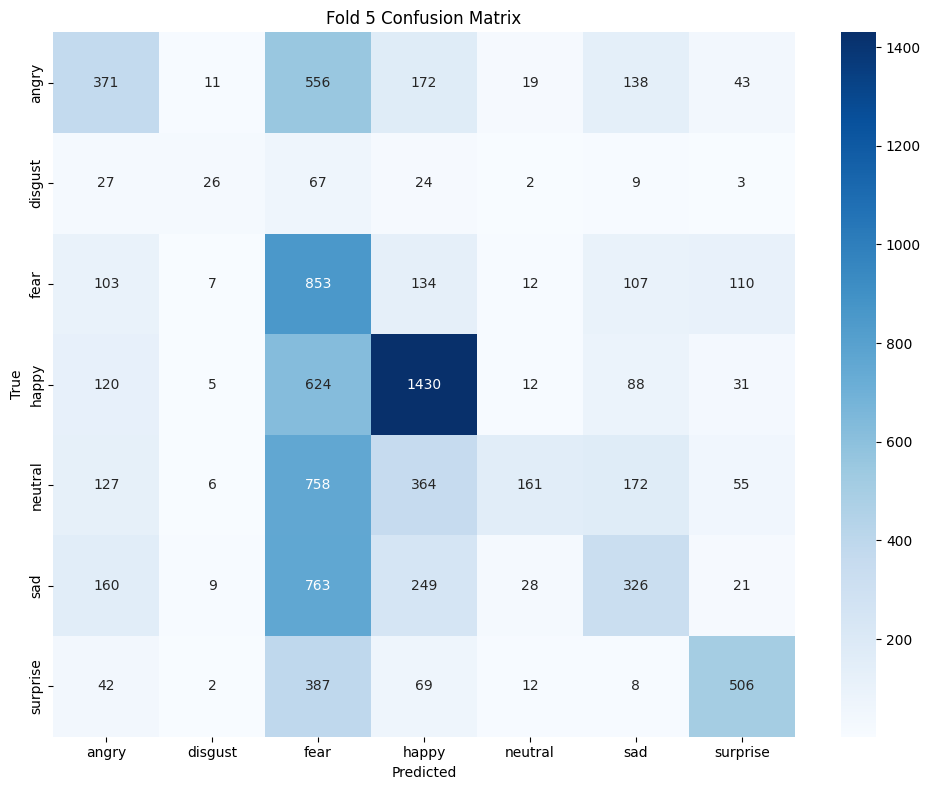


CROSS-VALIDATION RESULTS
Average Final Validation Accuracy: 0.3982 ± 0.0250


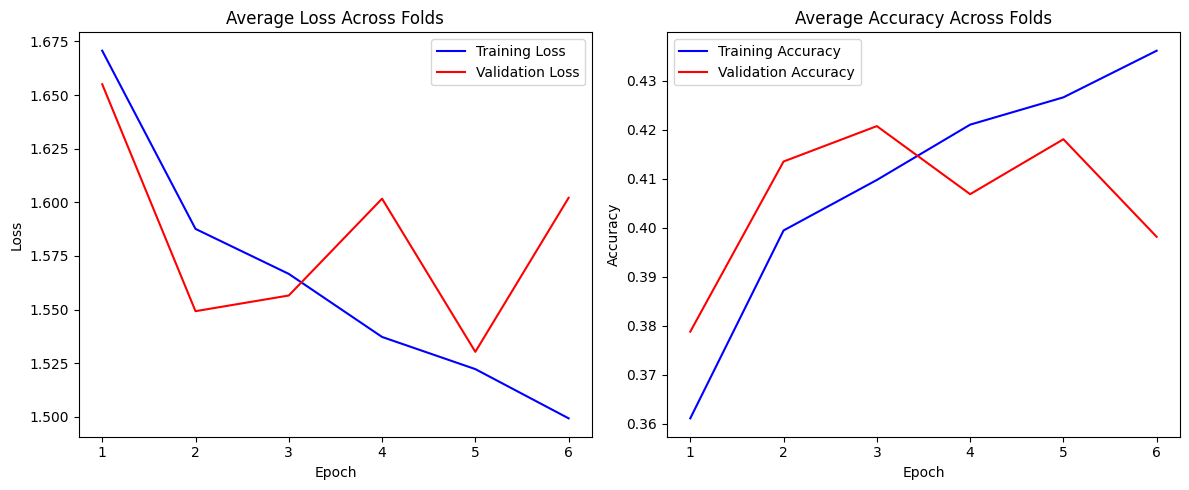


Per-Fold Validation Accuracies:
Fold 1: 0.4278
Fold 2: 0.3588
Fold 3: 0.4224
Fold 4: 0.3880
Fold 5: 0.3937


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.models import resnet50, ResNet50_Weights

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Implement 5-fold cross-validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_results = []

# To store results across folds
all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\n{'='*50}")
    print(f"FOLD {fold+1}/{NUM_FOLDS}")
    print(f"{'='*50}")

    # Create data loaders for this fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

    # Create a fresh model for this fold
    model = create_model()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

    # Training loop
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Final evaluation for this fold
    final_val_loss, final_val_acc, val_preds, val_labels = evaluate(model, val_loader, criterion)

    # Calculate classification report and confusion matrix
    class_names = dataset.classes
    report = classification_report(val_labels, val_preds, target_names=class_names)
    conf_matrix = confusion_matrix(val_labels, val_preds)

    print("\nClassification Report:")
    print(report)

    print("\nConfusion Matrix:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Store results for this fold
    fold_results.append({
        'fold': fold + 1,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'final_val_acc': final_val_acc,
        'conf_matrix': conf_matrix,
        'report': report
    })

    # Collect for averaging later
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)

    # Save model for this fold
    torch.save(model.state_dict(), f'/content/resnet50_fold{fold+1}.pt')

# Calculate average metrics across folds
avg_train_losses = np.mean(np.array(all_train_losses), axis=0)
avg_train_accs = np.mean(np.array(all_train_accs), axis=0)
avg_val_losses = np.mean(np.array(all_val_losses), axis=0)
avg_val_accs = np.mean(np.array(all_val_accs), axis=0)

# Final accuracy across all folds
final_accuracies = [result['final_val_acc'] for result in fold_results]
avg_final_acc = np.mean(final_accuracies)
std_final_acc = np.std(final_accuracies)

print(f"\n{'='*50}")
print(f"CROSS-VALIDATION RESULTS")
print(f"{'='*50}")
print(f"Average Final Validation Accuracy: {avg_final_acc:.4f} ± {std_final_acc:.4f}")

# Plot training and validation curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), avg_train_losses, 'b-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS+1), avg_val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), avg_train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), avg_val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Print per-fold results
print("\nPer-Fold Validation Accuracies:")
for i, acc in enumerate(final_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")# Implement 5-fold cross-validation